# Калибровка вероятности дефолта

Для принятия решения важно не только учметь разделять между собой "хороших" клиентов от "плохих", но и достаточно точно прогнозировать вероятность начтупления дефолта. Когда качество разделения модели достаточно сильное, но попадание в реальные риски плохое можно производить калибровку - несложное преобразование прогноза вероятности дефолта. 

В данном ноутбуке мы рассмотрим несколько подходов к калибровки модели.

Загрузим сначала выборку с данными.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('calibration.csv')
df.head(2)

,pd,default_flg,category_feature
0,0.147840,1,C
1,0.112133,0,E


In [2]:
df.shape

(30000, 3)

В данной выборке присутствует 30000 наблюдений, и три поля.

# Gain Chart

Один из способов визуально отобразить качество прогноза - диаграма gain chart.  
Выборка разбивается на равные по количеству бакеты в зависимости от значения прогноза. В каждом бакете считается средний прогноз и частота наступления дефолта.

In [3]:
def plot_gain_chart(target, prob, num_buck=10):    
    data = pd.DataFrame({'target': target, 'predict': prob})
    buckets = pd.qcut(prob, q=num_buck)
    aggregated = data.groupby(buckets).agg({'target': 'mean', 'predict': 'mean'})
    aggregated = aggregated.sort_index(ascending=False).reset_index(drop=True)
    aggregated.plot(kind='bar', grid=True)

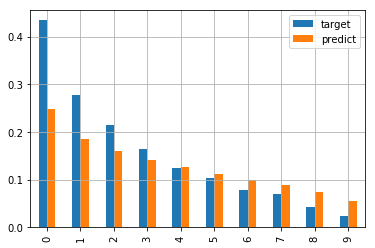

In [4]:
plot_gain_chart(df['default_flg'], df['pd'])

По данной диаграмме видно, что среди бакетов [0, 1, 2] реальная частота дефолтов оказывается выше, чем средний прогноз.  

К массиву `df['pd']` можно применять арифметические преобразования, которые применяются поэлементно.

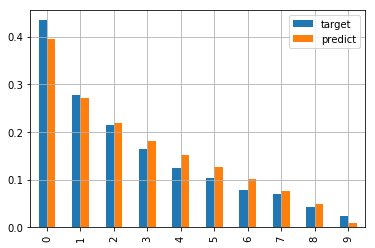

In [5]:
plot_gain_chart(df['default_flg'], 2 * df['pd'] - 0.1)

Так же можно применять и любые преобразования из из numpy, которые так же поэлементные. Например, `np.exp()` или `np.sin()`.

# Калибровка логистической регрессией

В логистической регрессии присутствует сигмоидное преобразование $\sigma(x) = \frac{1}{1+exp(-x)}$.  

**Задание. Напишите функцию логистического преобразования, которое является обратным к сигмоидному.**

In [6]:
def logit(x):
    return np.log(x / (1 - x))

Создадим новый столбец `logit` в таблице

In [7]:
df['logit'] = logit(df['pd'])

**Задание. Нарисуйте теперь диаграмму рассеивания между `logit` и `pd`. Точки должны лечь на часть сигмоиды.**

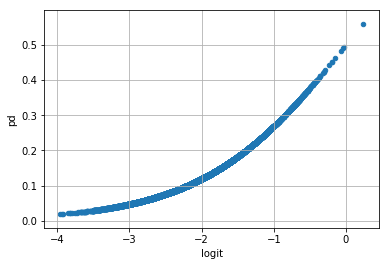

In [8]:
df.plot(x='logit', y='pd', kind='scatter', grid=True);

Произведем калибровку, обучив логистическую регрессию на одном признаке `df['logit']`.  
В scikit-learn алгоритм машинного обучения выглядят следующим образом:

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()                                      # Определяем объект - классификатор
classifier.fit( df[['logit']], df['default_flg'] )                     # Производим обучение, вызвав метод fit
df['pd_calibrated'] = classifier.predict_proba( df[['logit']] )[:, 1]  # Считаем прогноз, записывая результат в таблицу

После обучения (запуска метода `.fit()`), у обекта `classifier` появляются атрибуты с коэффициентами

In [10]:
classifier.intercept_  # свободный член

array([ 1.99366937])

In [11]:
classifier.coef_       # коэффициенты перед признаками, в нашем случае всего одно число, так как признак один

array([[ 2.0059524]])

Посмотрим как теперь выглядит график gain chart.

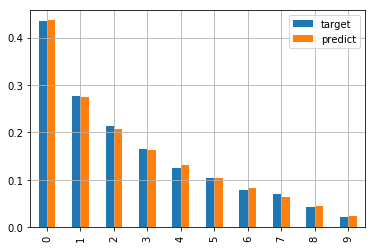

In [12]:
plot_gain_chart(df['default_flg'], df['pd_calibrated'])

Столбики с прогнозом и с частотой дефолтов стали гораздо ближе.  
Помимо визуализации полезно так же считать формальные метрики.  
**Задание. Сравните между собой по разным метрикам точность двух прогнозов. Объясните результаты.**

In [13]:
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

metrics = pd.DataFrame()  # можно создавать пустую таблицу, заполняя её позже

def add_metrics(predict):
    # для обращения к ячейкам есть метод .loc[название строки, название столбца]
    metrics.loc[predict, 'MSE'     ] = mean_squared_error (df['default_flg'], df[predict])
    metrics.loc[predict, 'AUC'     ] = roc_auc_score      (df['default_flg'], df[predict])
    metrics.loc[predict, 'log_loss'] = log_loss           (df['default_flg'], df[predict])
    
for predict in ['pd', 'pd_calibrated']:  # в теле цикла переменная predict последовательно принимает значения
    add_metrics(predict)                 # 'pd', 'pd_calibrated'

metrics

,MSE,AUC,log_loss
pd,0.119903,0.747852,0.389770
pd_calibrated,0.114596,0.747852,0.374522


# Калибровка линейной регрессией

Воспользуемся теперь линейной регрессией.  
Интерфейс обучения модели практически такой же.  

In [14]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(df[['pd']], df['default_flg'])
df['pd_linear'] = regressor.predict(df[['pd']])

**Задание. Посчитайте метрики для прогноза `pd_linear`. Обясните результаты.**

In [15]:
add_metrics('pd_linear')
metrics

,MSE,AUC,log_loss
pd,0.119903,0.747852,0.389770
pd_calibrated,0.114596,0.747852,0.374522
pd_linear,0.114873,0.747852,0.402655


# Калибровка [Isotonic regression](http://scikit-learn.org/stable/modules/isotonic.html)

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_isotonic_regression_0011.png" width=500>

Логистическая и линейная регрессия находи зависимость между наборами признаков и целевой переменной, в isotonic ищет зависимость между всего одним признаком и целевой переменной. Но за то поиск происходит в достаточно большом классе функций - все возможные монотонные преобразования.  

Из за наличия только одного признака в метод `.fit()` и `.predict()` нужно подавать одномерный массив с признаком, а не двумерную матрицу, как в прошлых моделях.

**Задание. Произведите калибровку isotonic regression и посчитайте метрики. Объясните результаты.**

In [16]:
from sklearn.isotonic import IsotonicRegression
reg = IsotonicRegression()
reg.fit(df['pd'], df['default_flg'])
df['pd_isotonic'] = reg.predict(df['pd'])

In [17]:
add_metrics('pd_isotonic')
metrics

,MSE,AUC,log_loss
pd,0.119903,0.747852,0.389770
pd_calibrated,0.114596,0.747852,0.374522
pd_linear,0.114873,0.747852,0.402655
pd_isotonic,0.114283,0.749341,0.373296


# information value

$$\hat{IV} = \sum_i
 \left(     \frac{bad_i}{bad_{total}} -     \frac{good_i}{good_{total}} \right)
 \left( \log\frac{bad_i}{bad_{total}} - \log\frac{good_i}{good_{total}} \right)
$$

In [18]:
def information_value(target, feature, num_buck=10):
    bucket = pd.qcut(feature, q=num_buck)
    data = pd.DataFrame({'target': target, 'bucket': bucket})
    agg = data.groupby(['bucket', 'target']).size().unstack().fillna(0)
    agg = agg / agg.sum()
    agg['iv'] = (agg[0] - agg[1]) * (np.log(np.clip(agg[0], 0.001, 1)) - np.log(np.clip(agg[1], 0.001, 1)))
    return agg['iv'].sum()

In [19]:
information_value(df['default_flg'], df['pd'])

0.84616205767765273

С помощью данной функции можно посчитать iv только для числового признака.

**Задание. Модифицируйте функцию, таким образом, чтобы на вход можно было бы подавать категориальный признак. Посчитайте iv у category_feature.**

# Калибровка по отдельным группам

In [20]:
import statsmodels.formula.api as smf

log_reg = smf.logit('default_flg ~ category_feature + logit', data=df).fit()
df['pd_category_calibration'] = log_reg.predict(df)
log_reg.summary2()

Optimization terminated successfully.
         Current function value: 0.371699
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             No. Iterations:    7.0000    
Dependent Variable:   default_flg       Pseudo R-squared:  0.133     
Date:                 2018-01-30 14:48  AIC:               22313.9569
No. Observations:     30000             BIC:               22363.8106
Df Model:             5                 Log-Likelihood:    -11151.   
Df Residuals:         29994             LL-Null:           -12862.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              2.0423   0.0801 25.4890 0.0000  1.8853  2.1993
category_feature[T.B] -0.4805   0.0643 -7.4745 0.0000 -0.6066 -0.3545
category_feature[T.C]  0.1853   0.0536  3.4566 0.0005  0.0802  0.2904
category_feature[T.D] -0.2401   0.0670 -3.5832 0.0003 -0.3714 -0.1088
category_feature[T.E]  0.0385   0.0537  0.7178 0.4729 -0.0667  0.1437
logit                  2.0119   0.0391 51.4125 0.0000  1.9352  2.0886
=====================================================================

"""

In [21]:
add_metrics('pd_category_calibration')
metrics

,MSE,AUC,log_loss
pd,0.119903,0.747852,0.389770
pd_calibrated,0.114596,0.747852,0.374522
pd_linear,0.114873,0.747852,0.402655
pd_isotonic,0.114283,0.749341,0.373296
pd_category_calibration,0.113862,0.754177,0.371699


# Ссылки
* [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
* [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) - книга на github по анализу данных в python.